# 1. 필요한 module import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

%matplotlib inline

batch_size = 64
learning_rate = 1e-3
epochs = 10

## CIFAR10 dataset download

- 이름에서 알 수 있듯이 10개의 class가 있다.

In [2]:
cifar_train = dsets.CIFAR10(root="CIFAR10/",
                            train=True,
                            transform=transforms.ToTensor(),
                            target_transform=None,
                            download=True)
cifar_test  = dsets.CIFAR10(root="CIFAR10/",
                          train=False,
                          transform=transforms.ToTensor(),
                          target_transform=None,
                          download=True)

Files already downloaded and verified
Files already downloaded and verified


# 2. 대략적인 데이터 형태

cifar_train 길이 : 50000
cifar_test  길이 : 10000
image data 형태 : torch.Size([3, 32, 32])
label           : 9


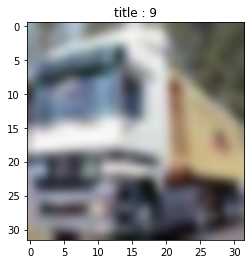

In [3]:
print(f'cifar_train 길이 : {len(cifar_train)}')
print(f'cifar_test  길이 : {len(cifar_test)}')

# 데이터 하나의 형태
img, label = cifar_train.__getitem__(1)
print(f'image data 형태 : {img.shape}')
print(f'label           : {label}')

# 그리기
img = img.numpy()
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]

img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title(f'title : {label}')
plt.imshow(img2, interpolation='bicubic')
plt.show()

## accuracy 계산 함수

In [4]:
def compute_acc(dloader=None, model=None):
    correct = 0
    total = 0

    for i, [imgs, labels] in enumerate(dloader):
        img = imgs
        label = Variable(labels).cuda()

        img = img.view(img.shape[0], img.shape[2] * img.shape[3])
        img = Variable(img, requires_grad=False).cuda()

        output = model(img)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()

    print(f'Accuracy of Test Data: {100 * correct/total}')

# 3. dataloader

In [5]:
train_loader = DataLoader(dataset=cifar_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          drop_last=True)
test_loader  = DataLoader(dataset=cifar_test,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4,
                          drop_last=True)

# 4. model 선언

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 100),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.layer(x)
        x = self.fc_layer(x)

        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

model = CNN().to(device)

DeferredCudaCallError: CUDA call failed lazily at initialization with error: name '_get_device_properties' is not defined

CUDA call was originally invoked at:

['  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/runpy.py", line 194, in _run_module_as_main\n    return _run_code(code, main_globals, None,\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/runpy.py", line 87, in _run_code\n    exec(code, run_globals)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance\n    app.start()\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start\n    self.io_loop.start()\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start\n    self.asyncio_loop.run_forever()\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/asyncio/base_events.py", line 570, in run_forever\n    self._run_once()\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once\n    handle._run()\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/asyncio/events.py", line 81, in _run\n    self._context.run(self._callback, *self._args)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>\n    lambda f: self._run_callback(functools.partial(callback, future))\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback\n    ret = callback()\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner\n    self.ctx_run(self.run)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/gen.py", line 775, in run\n    yielded = self.gen.send(value)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one\n    yield gen.maybe_future(dispatch(*args))\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper\n    yielded = ctx_run(next, result)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell\n    yield gen.maybe_future(handler(stream, idents, msg))\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper\n    yielded = ctx_run(next, result)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request\n    self.do_execute(\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper\n    yielded = ctx_run(next, result)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute\n    res = shell.run_cell(code, store_history=store_history, silent=silent)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell\n    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2877, in run_cell\n    result = self._run_cell(\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2923, in _run_cell\n    return runner(coro)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner\n    coro.send(None)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async\n    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes\n    if (await self.run_code(code, result,  async_=asy)):\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n', '  File "<ipython-input-1-cebd7381bf09>", line 2, in <module>\n    import torch\n', '  File "<frozen importlib._bootstrap>", line 991, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 975, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 671, in _load_unlocked\n', '  File "<frozen importlib._bootstrap_external>", line 783, in exec_module\n', '  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/torch/__init__.py", line 500, in <module>\n    _C._initExtension(manager_path())\n', '  File "<frozen importlib._bootstrap>", line 991, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 975, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 671, in _load_unlocked\n', '  File "<frozen importlib._bootstrap_external>", line 783, in exec_module\n', '  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/torch/cuda/__init__.py", line 119, in <module>\n    _lazy_call(_check_capability)\n', '  File "/home/r320/anaconda3/envs/vonenet/lib/python3.8/site-packages/torch/cuda/__init__.py", line 117, in _lazy_call\n    _queued_calls.append((callable, traceback.format_stack()))\n']

# 5. loss, optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 6. train

In [ ]:
# from tqdm import tqdm

for epoch in range(epochs):
    for img, label in train_loader:
        x = Variable(img).to(device)
        y = Variable(label).to(device)

        optimizer.zero_grad()

        output = model.forward(x)
        loss = loss_fn(output, y)

        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'epoch: {epoch:3d}  loss: {loss:4f}')

### drop out 결과
- 